In [1]:
import keras
from keras.datasets import mnist
from keras.layers import Activation, Input, Embedding, LSTM, Dense, Lambda, GaussianNoise, concatenate
from keras.models import Model
import numpy as np
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Activation
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, merge
from keras.optimizers import SGD, Adam, RMSprop
from keras.constraints import max_norm
from keras.layers import MaxPooling2D, Dropout, Dense, Flatten, Activation, Conv2D
from keras.models import Sequential
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy
import matplotlib.pyplot as plt


Using TensorFlow backend.


# Load the data

In [2]:
nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# convert y_train and y_test to categorical binary values 
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
Y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

# Preprocessing the Data

In [5]:
# Reshape them to batch_size, width,height,#channels
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the values
X_train /= 255
X_test /= 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [6]:
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Define Teacher Model

In [7]:
# Teacher model

input_shape = (28, 28, 1) # Input shape of each image

# Hyperparameters
nb_filters = 64 # number of convolutional filters to use
pool_size = (2, 2) # size of pooling area for max pooling
kernel_size = (3, 3) # convolution kernel size

teacher = Sequential()
teacher.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
teacher.add(Conv2D(64, (3, 3), activation='relu'))
teacher.add(MaxPooling2D(pool_size=(2, 2)))

teacher.add(Dropout(0.25)) # For reguralization

teacher.add(Flatten())
teacher.add(Dense(128, activation='relu'))
teacher.add(Dropout(0.5)) # For reguralization

teacher.add(Dense(nb_classes))
teacher.add(Activation('softmax')) # Note that we add a normal softmax layer to begin with

teacher.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

print(teacher.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________

# Define Student Model

In [8]:
# Student model that is stand-alone. We will evaluate its accuracy compared to a teacher trained student model

student = Sequential()
student.add(Flatten(input_shape=input_shape))
student.add(Dense(32, activation='relu'))
student.add(Dropout(0.2))
student.add(Dense(nb_classes))
student.add(Activation('softmax'))

#sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
student.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

student.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


# Training the Teacher model

In [9]:
# Train the teacher model as usual
'''

log_dir = 'logs/teacher/'
logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)

epochs = 500
batch_size = 256
teacher.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test),
           callbacks=[logging,checkpoint] )
'''

"\n\nlog_dir = 'logs/teacher/'\nlogging = TensorBoard(log_dir=log_dir)\ncheckpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',\n        monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)\n\nepochs = 500\nbatch_size = 256\nteacher.fit(X_train, Y_train,\n          batch_size=batch_size,\n          epochs=epochs,\n          verbose=1,\n          validation_data=(X_test, Y_test),\n           callbacks=[logging,checkpoint] )\n"

In [10]:
teacher.load_weights("ep183-acc0.9988-val_acc0.9949-loss0.0040-val_loss0.0327.h5")

score = teacher.evaluate(X_test, Y_test)

print(score)

10000/10000 [==============================] - 2s 235us/step
[0.0327168962046811, 0.9949]


# Define a new model that outputs only teacher logits

In [11]:
# Raise the temperature of teacher model and gather the soft targets

#Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(teacher.input, teacher.get_layer('dense_2').output)


In [12]:
teacher_WO_Softmax.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
__________

# Define a manual softmax function

In [13]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

# Understanding the concept of temperature in softmax activation

[[6.2035841e-29 3.8803228e-31 1.1746689e-33 7.2228541e-28 1.9147977e-16
  9.1969972e-24 2.1563771e-36 4.2656528e-20 1.5456886e-19 1.0000000e+00]]


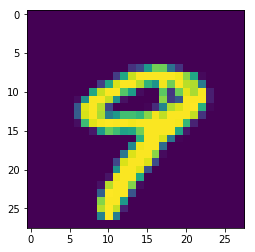

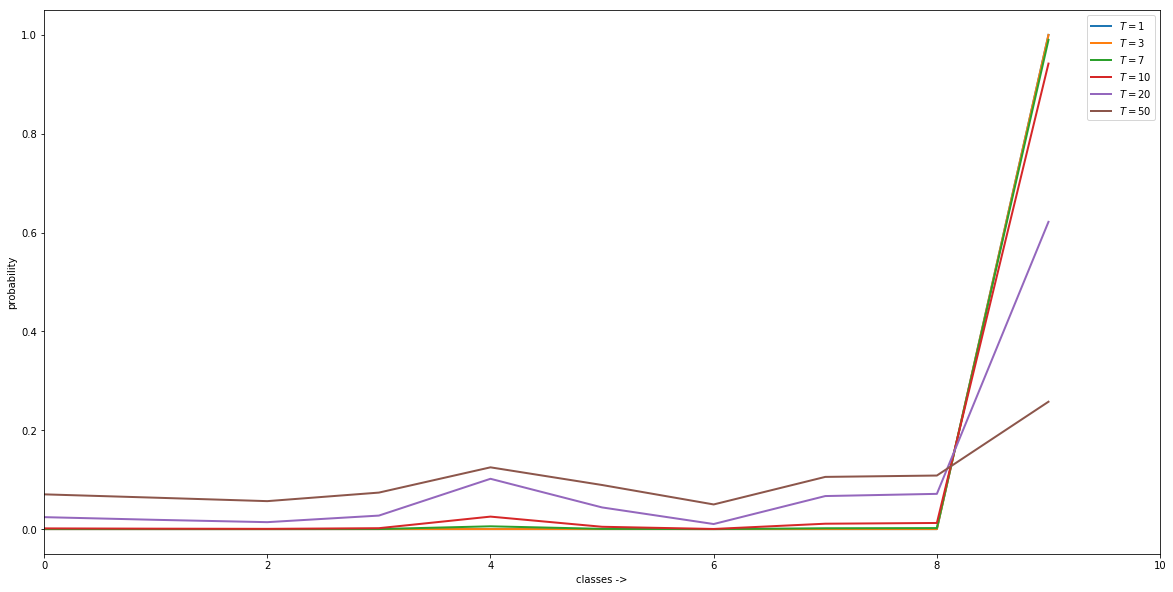

In [14]:
# For example, just grab the first image and lets see how softening of probabilities work
intermediate_output = teacher_WO_Softmax.predict(X_test[9].reshape(1,28,28,1))
print(softmax(intermediate_output))

pixels = X_test[9]
pixels = pixels.reshape((28, 28))
plt.imshow(pixels)
plt.savefig('Kimg.jpg')
plt.show()


# logits for the first number in test dataset
x = intermediate_output[0]
plt.figure(figsize=(20, 10));

temperature = [1,3,7,10,20,50]

for temp in temperature:
    plt.plot((softmax(x/temp)), label='$T='+str(temp)+'$', linewidth=2);
    plt.legend();
plt.xlabel('classes ->');
plt.ylabel('probability');
plt.xlim([0, 10]);
plt.savefig('Kgraph.jpg')
plt.show()


# Prepare the soft targets and the target data for student to be trained upon

In [15]:
temp = 1
teacher_train_logits = teacher_WO_Softmax.predict(X_train)
teacher_test_logits = teacher_WO_Softmax.predict(X_test) # This model directly gives the logits ( see the teacher_WO_softmax model above)

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/temp
test_logits_T = teacher_test_logits / temp 

#Y_train_soft = softmax(train_logits_T)
#Y_test_soft = softmax(test_logits_T)

Y_train_soft = []
Y_test_soft = []

for i in range( len( train_logits_T ) ):
  Y_train_soft.append( softmax( train_logits_T[i] ) )

for i in range( len( test_logits_T ) ):
  Y_test_soft.append( softmax( test_logits_T[i] ) )

#len(Y_train_soft[0])
Y_train_soft = np.array(Y_train_soft)
Y_test_soft = np.array(Y_test_soft)


# Concatenate so that this becomes a 10 + 10 dimensional vector
Y_train_new = np.concatenate([Y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([Y_test, Y_test_soft], axis =1)

In [16]:
Y_train_new[0]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.5356115e-27, 3.4459211e-22,
       7.7777399e-35, 1.1800338e-06, 3.3861200e-35, 9.9999881e-01,
       1.0668360e-24, 3.5405121e-34, 4.3196108e-20, 1.4041691e-19],
      dtype=float32)

In [18]:
train_logits_T[0]/10

array([-3.3319924, -2.0998735, -5.0118265,  1.4770977, -5.094985 ,
        2.8420944, -2.67764  , -4.8602676, -1.6167591, -1.4988725],
      dtype=float32)

In [17]:
# This is a standalone student model (same number of layers as original student model) trained on same data
# for comparing it with teacher trained student.
student = Sequential()
student.add(Flatten(input_shape=input_shape))
student.add(Dense(32, activation='relu'))
student.add(Dropout(0.2))
student.add(Dense(nb_classes))
student.add(Activation('softmax'))

#sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
student.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy']
               )

In [18]:
log_dir = 'logs/pure_student/'

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-acc{acc:.4f}-val_acc{val_acc:.4f}-loss{loss:.4f}-val_loss{val_loss:.4f}.h5',
        monitor='val_acc', save_weights_only=True, save_best_only=True, period=3)

history = student.fit(X_train, Y_train,
          batch_size=256,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test),
           callbacks=[logging,checkpoint] )

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 1s 19us/step - loss: 0.7256 - acc: 0.7850 - val_loss: 0.3238 - val_acc: 0.9114
Epoch 2/500
60000/60000 [==============================] - 1s 15us/step - loss: 0.3835 - acc: 0.8885 - val_loss: 0.2505 - val_acc: 0.9309
Epoch 3/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.3210 - acc: 0.9052 - val_loss: 0.2197 - val_acc: 0.9390
Epoch 4/500
60000/60000 [==============================] - 1s 15us/step - loss: 0.2874 - acc: 0.9161 - val_loss: 0.1949 - val_acc: 0.9449
Epoch 5/500
60000/60000 [==============================] - 1s 15us/step - loss: 0.2637 - acc: 0.9228 - val_loss: 0.1793 - val_acc: 0.9477
Epoch 6/500
60000/60000 [==============================] - 1s 15us/step - loss: 0.2489 - acc: 0.9270 - val_loss: 0.1685 - val_acc: 0.9506
Epoch 7/500
60000/60000 [==============================] - 1s 15us/step - loss: 0.2385 - acc: 0.9292 - val_loss: 0.1589 - 

In [ ]:
last_acc = history.history['acc'][-1]
last_val_acc = history.history['val_acc'][-1]
last_loss = history.history['loss'][-1]
last_val_loss = history.history['val_loss'][-1]

hist = "acc{0:.4f}-val_acc{0:.4f}-loss{0:.4f}-val_loss{0:.4f}".format(last_acc,last_val_acc,last_loss,last_val_loss)
student.save_weights(log_dir + "last_"+ hist + ".h5")

# Student

In [19]:
studentX = Sequential()
studentX.add(Flatten(input_shape=input_shape))
studentX.add(Dense(32, activation='relu'))
studentX.add(Dropout(0.2))
studentX.add(Dense(nb_classes))
studentX.add(Activation('softmax'))



#sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
studentX.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy']
                )



In [20]:
log_dir = 'logs/no_loss_function/'
logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-acc{acc:.4f}-val_acc{val_acc:.4f}-loss{loss:.4f}-val_loss{val_loss:.4f}.h5',
        monitor='val_acc', save_weights_only=True, save_best_only=True, period=3)


history = studentX.fit(X_train, Y_train_soft,
                      batch_size=256,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_test, Y_test),
                      callbacks=[logging,checkpoint] )

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 1s 18us/step - loss: 0.7026 - acc: 0.7954 - val_loss: 0.3142 - val_acc: 0.9123
Epoch 2/500
60000/60000 [==============================] - 1s 15us/step - loss: 0.3696 - acc: 0.8931 - val_loss: 0.2450 - val_acc: 0.9295
Epoch 3/500
60000/60000 [==============================] - 1s 14us/step - loss: 0.3122 - acc: 0.9092 - val_loss: 0.2199 - val_acc: 0.9384
Epoch 4/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.2807 - acc: 0.9169 - val_loss: 0.1934 - val_acc: 0.9438
Epoch 5/500
60000/60000 [==============================] - 1s 15us/step - loss: 0.2619 - acc: 0.9229 - val_loss: 0.1797 - val_acc: 0.9475
Epoch 6/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.2452 - acc: 0.9259 - val_loss: 0.1701 - val_acc: 0.9502
Epoch 7/500
60000/60000 [==============================] - 1s 15us/step - loss: 0.2359 - acc: 0.9306 - val_loss: 0.1582 - 

In [ ]:
last_acc = history.history['acc'][-1]
last_val_acc = history.history['val_acc'][-1]
last_loss = history.history['loss'][-1]
last_val_loss = history.history['val_loss'][-1]

hist = "acc{0:.4f}-val_acc{0:.4f}-loss{0:.4f}-val_loss{0:.4f}".format(last_acc,last_val_acc,last_loss,last_val_loss)
studentX.save_weights(log_dir + "last_"+ hist + ".h5")

# StudentA

In [21]:
studentA = Sequential()
studentA.add(Flatten(input_shape=input_shape))
studentA.add(Dense(32, activation='relu'))
studentA.add(Dropout(0.2))
studentA.add(Dense(nb_classes))
studentA.add(Activation('softmax'))


##sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
studentA.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

#studentA = Model(student.input,student.output)
studentA.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                25120     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                330       
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Remove the softmax layer from the student network
#student.layers.pop()

# Now collect the logits from the last layer
logits = studentA.layers[-2].output # This is going to be a tensor. And hence it needs to pass through a Activation layer
probs = Activation('softmax')(logits)

# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])


# This is our new student model
studentA = Model(studentA.input, output)

studentA.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
flatten_5_input (InputLayer)    (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 784)          0           flatten_5_input[0][0]            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 32)           25120       flatten_5[0][0]                  
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 32)           0           dense_9[0][0]                    
__________________________________________________________________________________________________
dense_10 (

In [23]:
studentA.predict( X_train[0].reshape(1,28,28,1) )

array([[0.11022913, 0.1789273 , 0.07496126, 0.10378706, 0.09180001,
        0.10597233, 0.08889865, 0.07031129, 0.1326415 , 0.04247146,
        0.11022913, 0.1789273 , 0.07496126, 0.10378706, 0.09180001,
        0.10597233, 0.08889865, 0.07031129, 0.1326415 , 0.04247146]],
      dtype=float32)

In [24]:
# This will be a teacher trained student model. 
# --> This uses a knowledge distillation loss function

# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_logits = y_true[: , :nb_classes], y_true[: , nb_classes:]
    
    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]
    
    loss = ( alpha*temp*logloss(y_logits, y_pred) ) + ( (1-alpha)*logloss(y_true,y_pred) ) 
    
    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)
  
# For testing use regular output probabilities - without temperature
def true_loss(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return logloss(y_true, y_pred)

def logits_loss(y_true, y_pred):
    y_true = y_true[:, nb_classes:]
    y_pred = y_pred[:, :nb_classes]
    return logloss(y_true, y_pred)

studentA.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.5),
    #loss='categorical_crossentropy',
    metrics=[acc] )#,true_loss,logits_loss


In [25]:
log_dir = 'logs/loss_function_a/'
logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-acc{acc:.4f}-val_acc{val_acc:.4f}-loss{loss:.4f}-val_loss{val_loss:.4f}.h5',
        monitor='val_acc', save_weights_only=True, save_best_only=True, period=3)

history = studentA.fit(X_train, Y_train_new,
                      batch_size=256,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_test, Y_test_new),
            callbacks=[logging,checkpoint])

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 2s 26us/step - loss: 0.7267 - acc: 0.7879 - val_loss: 0.3124 - val_acc: 0.9119
Epoch 2/500
60000/60000 [==============================] - 1s 18us/step - loss: 0.3808 - acc: 0.8869 - val_loss: 0.2486 - val_acc: 0.9250
Epoch 3/500
60000/60000 [==============================] - 1s 18us/step - loss: 0.3187 - acc: 0.9068 - val_loss: 0.2151 - val_acc: 0.9362
Epoch 4/500
60000/60000 [==============================] - 1s 20us/step - loss: 0.2862 - acc: 0.9152 - val_loss: 0.1925 - val_acc: 0.9427
Epoch 5/500
60000/60000 [==============================] - 1s 20us/step - loss: 0.2645 - acc: 0.9226 - val_loss: 0.1816 - val_acc: 0.9445
Epoch 6/500
60000/60000 [==============================] - 1s 21us/step - loss: 0.2488 - acc: 0.9264 - val_loss: 0.1716 - val_acc: 0.9480
Epoch 7/500
60000/60000 [==============================] - 1s 20us/step - loss: 0.2367 - acc: 0.9303 - val_loss: 0.1655 - 

In [ ]:
last_acc = history.history['acc'][-1]
last_val_acc = history.history['val_acc'][-1]
last_loss = history.history['loss'][-1]
last_val_loss = history.history['val_loss'][-1]

hist = "acc{0:.4f}-val_acc{0:.4f}-loss{0:.4f}-val_loss{0:.4f}".format(last_acc,last_val_acc,last_loss,last_val_loss)
studentA.save_weights(log_dir + "last_"+ hist + ".h5")

# StudentB

In [26]:
studentB = Sequential()
studentB.add(Flatten(input_shape=input_shape))
studentB.add(Dense(32, activation='relu'))
studentB.add(Dropout(0.2))
studentB.add(Dense(nb_classes))
studentB.add(Activation('softmax'))


##sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
studentB.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
#studentB = Model(student.input,student.output)
studentB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                25120     
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                330       
_________________________________________________________________
activation_8 (Activation)    (None, 10)                0         
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Remove the softmax layer from the student network
#student.layers.pop()

# Now collect the logits from the last layer
logits = studentB.layers[-2].output # This is going to be a tensor. And hence it needs to pass through a Activation layer
probs = Activation('softmax')(logits)

# softed probabilities at raised temperature
#logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = Activation('softmax')(logits)#(logits_T)

output = concatenate([probs, probs_T])


# This is our new student model
studentB = Model(studentB.input, output)

studentB.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
flatten_6_input (InputLayer)    (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 784)          0           flatten_6_input[0][0]            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 32)           25120       flatten_6[0][0]                  
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 32)           0           dense_11[0][0]                   
__________________________________________________________________________________________________
dense_12 (

In [28]:
studentB.predict( X_train[0].reshape(1,28,28,1) )

array([[0.08061464, 0.10786386, 0.12631465, 0.07207894, 0.08930514,
        0.09400028, 0.08867763, 0.09583522, 0.07001819, 0.1752915 ,
        0.08061464, 0.10786386, 0.12631465, 0.07207894, 0.08930514,
        0.09400028, 0.08867763, 0.09583522, 0.07001819, 0.1752915 ]],
      dtype=float32)

In [29]:
# This will be a teacher trained student model. 
# --> This uses a knowledge distillation loss function

# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha,beta,gamma):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_logits = y_true[: , :nb_classes], y_true[: , nb_classes:]
    
    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]
    
    loss = ( alpha*logloss(y_true,y_logits) ) + ( beta*logloss(y_true, y_pred) ) +( gamma*logloss(y_logits, y_pred) )
   
    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)
  
# For testing use regular output probabilities - without temperature
def teacher_loss(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_true[:, nb_classes:]
    return logloss(y_true, y_pred)
  
def student_loss(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return logloss(y_true, y_pred)

def apprentice_loss(y_true, y_pred):
    y_true = y_true[:, nb_classes:]
    y_pred = y_pred[:, :nb_classes]
    return logloss(y_true, y_pred)

studentB.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 1,0.5,0.5),
    #loss='categorical_crossentropy',
    metrics=[acc] )


In [30]:
log_dir = 'logs/loss_function_b/'
logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-acc{acc:.4f}-val_acc{val_acc:.4f}-loss{loss:.4f}-val_loss{val_loss:.4f}.h5',
        monitor='val_acc', save_weights_only=True, save_best_only=True, period=3)

history = studentB.fit(X_train, Y_train_new,
                      batch_size=256,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_test, Y_test_new),
            callbacks=[logging,checkpoint])

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.7071 - acc: 0.7963 - val_loss: 0.3558 - val_acc: 0.9098
Epoch 2/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.3871 - acc: 0.8859 - val_loss: 0.2815 - val_acc: 0.9270
Epoch 3/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.3260 - acc: 0.9042 - val_loss: 0.2491 - val_acc: 0.9349
Epoch 4/500
60000/60000 [==============================] - 1s 18us/step - loss: 0.2942 - acc: 0.9132 - val_loss: 0.2280 - val_acc: 0.9389
Epoch 5/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.2684 - acc: 0.9197 - val_loss: 0.2153 - val_acc: 0.9435
Epoch 6/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2519 - acc: 0.9248 - val_loss: 0.1991 - val_acc: 0.9480
Epoch 7/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.2403 - acc: 0.9281 - val_loss: 0.1913 - 

In [ ]:
last_acc = history.history['acc'][-1]
last_val_acc = history.history['val_acc'][-1]
last_loss = history.history['loss'][-1]
last_val_loss = history.history['val_loss'][-1]

hist = "acc{0:.4f}-val_acc{0:.4f}-loss{0:.4f}-val_loss{0:.4f}".format(last_acc,last_val_acc,last_loss,last_val_loss)
studentB.save_weights(log_dir + "last_"+ hist + ".h5")

# Training Together

In [31]:
# Teacher model

input_shape = (28, 28, 1) # Input shape of each image

# Hyperparameters
nb_filters = 64 # number of convolutional filters to use
pool_size = (2, 2) # size of pooling area for max pooling
kernel_size = (3, 3) # convolution kernel size

teacher = Sequential()
teacher.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
teacher.add(Conv2D(64, (3, 3), activation='relu'))
teacher.add(MaxPooling2D(pool_size=(2, 2)))

teacher.add(Dropout(0.25)) # For reguralization

teacher.add(Flatten())
teacher.add(Dense(128, activation='relu'))
teacher.add(Dropout(0.5)) # For reguralization

teacher.add(Dense(nb_classes))
teacher.add(Activation('softmax')) # Note that we add a normal softmax layer to begin with

teacher.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])


print(teacher.summary())
# This is a standalone student model (same number of layers as original student model) trained on same data
# for comparing it with teacher trained student.
student = Sequential()
student.add(Flatten(input_shape=input_shape))
student.add(Dense(32, activation='relu'))
student.add(Dropout(0.2))
student.add(Dense(nb_classes))
student.add(Activation('softmax'))

student.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
__________

In [32]:
#label = Input(shape=(416, 416, 3))
    
student_layer = student.layers[-1].output # This is going to be a tensor. And hence it needs to pass through a Activation layer

teacher_layer =  teacher.layers[-1].output


output = concatenate([student_layer, teacher_layer])


# This is our new student model
student_teacher = Model( [student.input,teacher.input] , output )

student_teacher.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_3_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 26, 26, 32)   320         conv2d_3_input[0][0]             
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 24, 24, 64)   18496       conv2d_3[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
flatten_8_

In [33]:
student_teacher.predict( [X_train[0].reshape(1,28,28,1), X_train[0].reshape(1,28,28,1) ] )

array([[0.08676973, 0.19380417, 0.13423479, 0.06452694, 0.06149981,
        0.07837997, 0.08502943, 0.09195261, 0.15730867, 0.04649395,
        0.10032204, 0.09717463, 0.09943859, 0.10250463, 0.10463606,
        0.09636588, 0.1015408 , 0.09520203, 0.09479003, 0.10802537]],
      dtype=float32)